In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import joblib
import sys
sys.path.append("../")

from cfmining.algorithms import MAPOFCEM
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import GeneralClassifier_Shap
from cfmining.action_set import ActionSet
from cfmining.utils import get_data_model

import dice_ml


%load_ext autoreload
%autoreload 2


## German

In [11]:
X_train, Y_train, model, _, individuals = get_data_model("german")
outlier_detection = joblib.load("../models/german/IsolationForest_test.pkl")

In [13]:
action_set = ActionSet(X = X_train)
not_mutable_features = ['Age', 'OwnsHouse', 'isMale', 'JobClassIsSkilled', 'Single', 'ForeignWorker', 'RentsHouse']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
continuous_features = ['Age', 'LoanDuration', 'LoanAmount', 'LoanRateAsPercentOfIncome','YearsAtCurrentHome']
for feat in action_set:
    if feat.name in not_mutable_features:
        feat.mutable = False
    if not feat.name in not_mutable_features:
        feat.mutable = True

    #if feat.name == "LoanDuration":
    #    feat.step_size = 6
    #    feat.step_type = "absolute"
    feat.step_direction = 0
    feat.update_grid()
percCalc = PercentileCalculator(action_set = action_set)

In [14]:
def summarize_results(results, outlier_detection, display_results = True):
    results["individual"] = results["individual"].apply(literal_eval)
    results["solutions"] = results["solutions"].apply(literal_eval)
    costs = []
    n_changes = []
    outliers = []
    for i in range(len(results)):
        criteria = PercentileCriterion(individuals.iloc[i].values, percCalc)
        solutions = results["solutions"].iloc[i]
        costs_ = [criteria.f(s) for s in solutions][0]
        individual = results["individual"].iloc[i]
        if len(individual) == 1:
            individual = individual[0]
        sol0 = results["solutions"].iloc[i][0]
        n_changes_ = sum([1 for i in range(len(individual)) if individual[i] != sol0[i]])

        n_changes.append(n_changes_)
        costs.append(costs_)
        outliers_ = [outlier_detection.predict(np.array(s)[None, :]) == -1 for s in solutions][0][0]
        outliers.append(outliers_)
    results["costs"] = costs
    results["outlier"] = outliers
    results["n_changes"] = n_changes

    if display_results:

        print(f"Time: {results['time'].mean():.3f} +- {results['time'].std():.3f}")
        print(f"Costs: {results['costs'].mean():.3f} +- {results['costs'].std():.3f}")
        print(f"Changes: {results['n_changes'].mean():.3f} +- {results['n_changes'].std():.3f}")
        print(f"Outliers: {results['outlier'].mean():.3f}")

        fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))
        axs[0].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["time"],
        )
        axs[0].set_xlabel("Probability")
        axs[0].set_ylabel("Time (s)")

        axs[1].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["costs"],
        )
        axs[1].set_xlabel("Probability")
        axs[1].set_ylabel("Costs")

        plt.tight_layout()
        plt.show()
    else:
        return results

Time: 0.155 +- 0.009
Costs: 0.525 +- 0.273
Changes: 1.629 +- 0.487
Outliers: 0.016


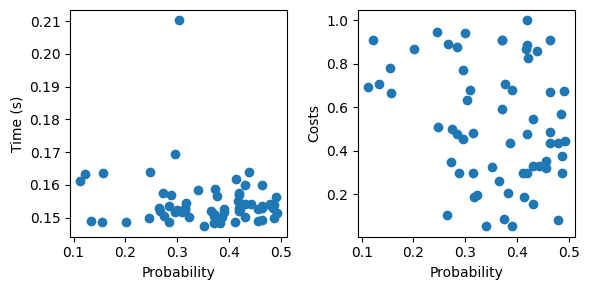

In [15]:
results = pd.read_csv("../results/german/dice_1sol.csv")
summarize_results(results, outlier_detection)

Time: 0.340 +- 0.453
Costs: 0.110 +- 0.078
Changes: 1.903 +- 0.900
Outliers: 0.000


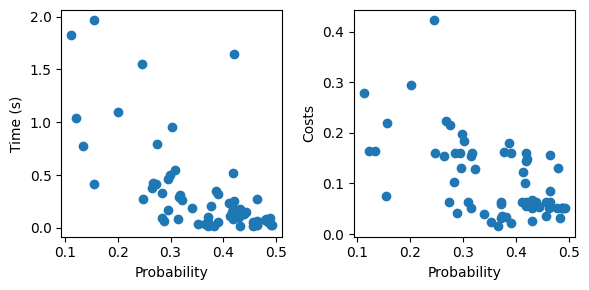

In [16]:
results = pd.read_csv("../results/german/mapofcem_percentile.csv")
summarize_results(results, outlier_detection)

Time: 0.130 +- 0.205
Costs: 0.102 +- 0.078
Changes: 1.968 +- 0.923
Outliers: 0.081


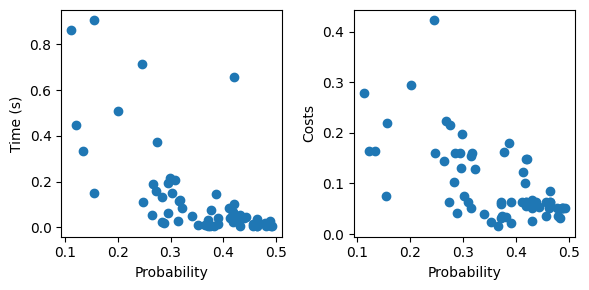

In [17]:
results = pd.read_csv("../results/german/mapocam_percentile.csv")
summarize_results(results, outlier_detection)

Time: 0.339 +- 0.451
Costs: 0.110 +- 0.078
Changes: 1.903 +- 0.900
Outliers: 0.000


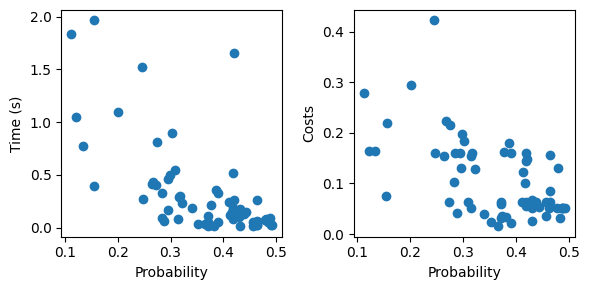

In [18]:
results = pd.read_csv("../results/german/mapofcem_v2_percentile.csv")
summarize_results(results, outlier_detection)

Time: 7.377 +- 0.359
Costs: 0.102 +- 0.078
Changes: 1.629 +- 0.794
Outliers: 0.097


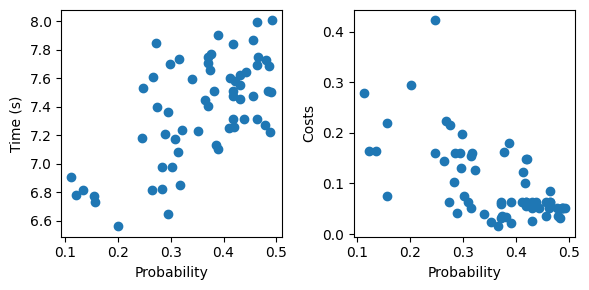

In [20]:
results = pd.read_csv("../results/german/bruteforce_percentiles.csv")
summarize_results(results, outlier_detection)

In [9]:
results_dict = []
for s in [1, 5, 10, 20, 25]:
    results = pd.read_csv(f"../results/german_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, outlier_detection, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    new_row["changes"] = results["n_changes"].mean()
    new_row["changes_std"] = results["n_changes"].std()
    new_row["outliers"] = results["outlier"].mean()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)

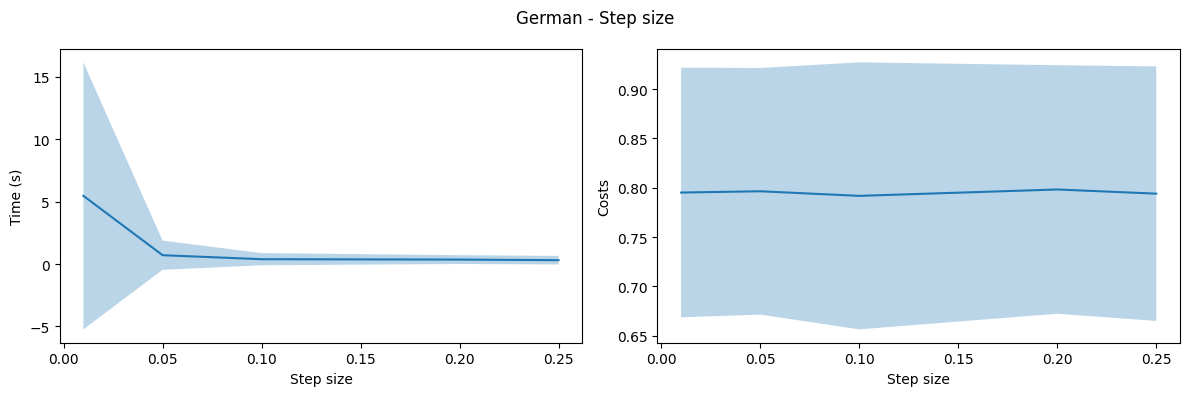

In [10]:
fig, axs  = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

axs[0].fill_between(
    results_dict["step_size"],
    results_dict["time"] - results_dict["time_std"],
    results_dict["time"] + results_dict["time_std"],
    alpha = 0.3,
)
axs[0].plot(results_dict["step_size"], results_dict["time"])
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")

axs[1].fill_between(
    results_dict["step_size"],
    results_dict["costs"] - results_dict["costs_std"],
    results_dict["costs"] + results_dict["costs_std"],
    alpha = 0.3,
)
axs[1].plot(results_dict["step_size"], results_dict["costs"])
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


plt.suptitle("German - Step size")
plt.tight_layout()
plt.show()

## Taiwan

In [21]:
X_train, Y_train, model, _, individuals = get_data_model("taiwan")
X_train = X_train.astype(int)
individuals = individuals.astype(int)
outlier_detection = joblib.load("../models/taiwan/IsolationForest_test.pkl")

Time: 0.244 +- 0.150
Costs: 0.940 +- 0.141
Changes: 1.640 +- 0.482
Outliers: 0.000


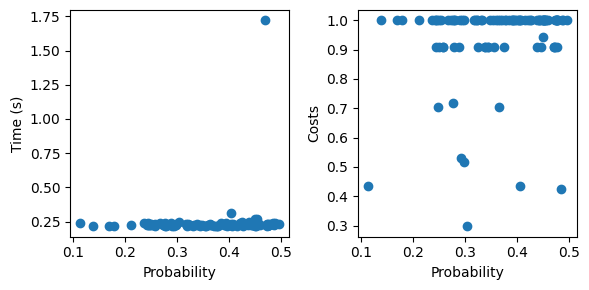

In [22]:
results = pd.read_csv("../results/taiwan/dice_1sol.csv")
summarize_results(results, outlier_detection)

Time: 2.633 +- 6.909
Costs: 0.941 +- 0.138
Changes: 2.230 +- 0.839
Outliers: 0.000


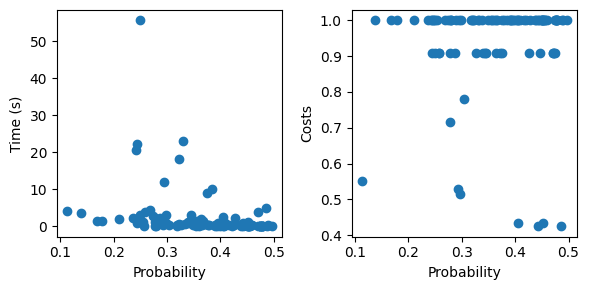

In [23]:
results = pd.read_csv("../results/taiwan/mapofcem_percentile.csv")
summarize_results(results, outlier_detection)

Time: 1.591 +- 4.935
Costs: 0.941 +- 0.138
Changes: 2.230 +- 0.839
Outliers: 0.000


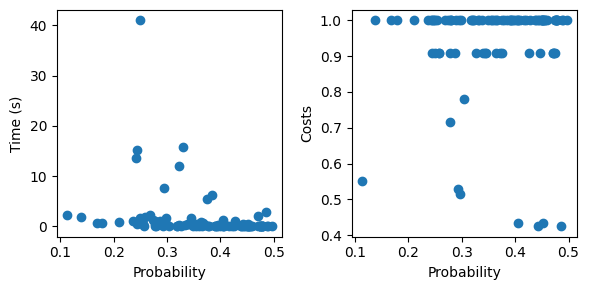

In [24]:
results = pd.read_csv("../results/taiwan/mapocam_percentile.csv")
summarize_results(results, outlier_detection)

Time: 2.609 +- 6.834
Costs: 0.941 +- 0.138
Changes: 2.230 +- 0.839
Outliers: 0.000


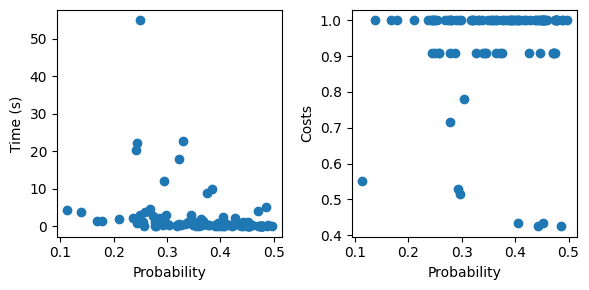

In [26]:
results = pd.read_csv("../results/taiwan/mapofcem_v2_percentile.csv")
summarize_results(results, outlier_detection)

Time: 909.372 +- 48.652
Costs: 0.939 +- 0.146
Changes: 1.809 +- 0.851
Outliers: 0.000


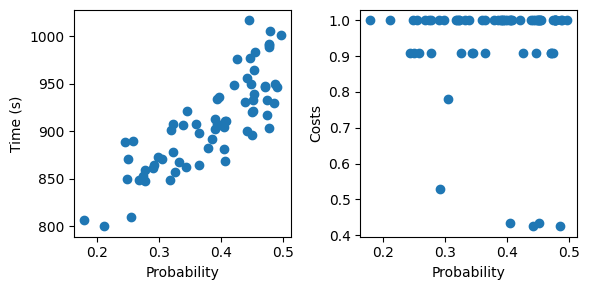

In [28]:
results = pd.read_csv("../results/taiwan/bruteforce_percentile.csv")
summarize_results(results, outlier_detection)

In [126]:
results_dict = []
for s in [5, 10, 20, 25]:
    results = pd.read_csv(f"../results/taiwan_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, outlier_detection, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    new_row["changes"] = results["n_changes"].mean()
    new_row["changes_std"] = results["n_changes"].std()
    new_row["outliers"] = results["outlier"].mean()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)

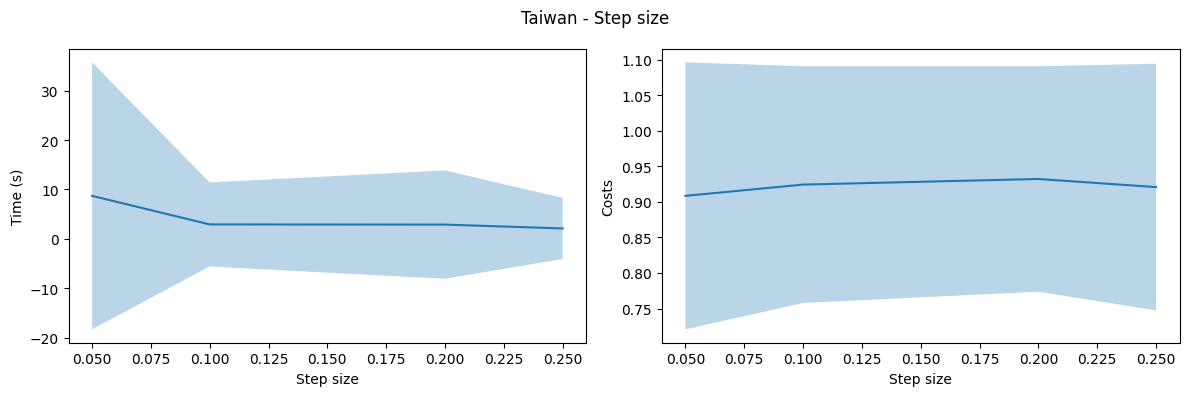

In [127]:
fig, axs  = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

axs[0].fill_between(
    results_dict["step_size"],
    results_dict["time"] - results_dict["time_std"],
    results_dict["time"] + results_dict["time_std"],
    alpha = 0.3,
)
axs[0].plot(results_dict["step_size"], results_dict["time"])
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")

axs[1].fill_between(
    results_dict["step_size"],
    results_dict["costs"] - results_dict["costs_std"],
    results_dict["costs"] + results_dict["costs_std"],
    alpha = 0.3,
)
axs[1].plot(results_dict["step_size"], results_dict["costs"])
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


plt.suptitle("Taiwan - Step size")
plt.tight_layout()
plt.show()